In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tensorflow import keras
import seaborn as sns
import random
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
grape_dir = "GRAPE2"
progression_dir = grape_dir + "/progression"
non_progression_dir = grape_dir + "/non_progression"

progression_images = os.listdir(progression_dir)
non_progression_images = os.listdir(non_progression_dir)

# Look at the number of samples in each dataset
print("Acrima dataset contains : ")
print(f"\t{len(progression_images)} images representing a VF with progressing glaucoma")
print(f"\t{len(non_progression_images)} images representing a VF with nonprogressing glaucoma")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'GRAPE2/progression'

In [3]:
import pathlib
import shutil


# Find the ratio between the two classes
progression_ratio = len(progression_images) / (len(non_progression_images) + 1e-8)

# Define the target ratio for balanced classes
target_ratio = 1.0  # You can adjust this value based on your preference

# Calculate the augmentation factor
augmentation_factor = int(target_ratio / progression_ratio)

# Data augmentation for progression images
datagen_progression = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=10.0,
    vertical_flip=True,
    fill_mode='nearest'
)

# Create augmented progression dataset
augmented_progression_dir = grape_dir + "/augmented_progression"
os.makedirs(augmented_progression_dir, exist_ok=True)

for image_name in progression_images:
    img_path = os.path.join(progression_dir, image_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    i = 0
    for batch in datagen_progression.flow(x, batch_size=1, save_to_dir=augmented_progression_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= augmentation_factor:
            break

# Delete the 'progression' folder
shutil.rmtree(progression_dir)

# Update the progression dataset path
progression_dir = augmented_progression_dir

# Display the updated class distribution
sns.set_style('darkgrid')
sns.barplot(x=['progression', 'non_progression'], y=[len(os.listdir(progression_dir)), len(os.listdir(non_progression_dir))])
plt.show()

NameError: name 'progression_images' is not defined

In [4]:
import splitfolders
base_ds = 'GRAPE2'
base_ds = pathlib.Path(base_ds)
img_height=256
img_width=256
batch_size=32
splitfolders.ratio(base_ds, output='images', seed=1321, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 948 files [00:00, 2635.08 files/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
shear_range=0.15,
zoom_range=0.15,
horizontal_flip=True)
train_ds = datagen.flow_from_directory(
    'images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen.flow_from_directory(
    'images/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 757 images belonging to 2 classes.


Found 94 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications import InceptionV3
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the InceptionV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(train_ds, epochs=230,validation_data=val_ds)

Epoch 1/230
24/24 [==============================] - 12s 380ms/step - loss: 1.6088 - accuracy: 0.3778 - val_loss: 0.6764 - val_accuracy: 0.6702
Epoch 2/230
24/24 [==============================] - 8s 324ms/step - loss: 0.7343 - accuracy: 0.5416 - val_loss: 0.6712 - val_accuracy: 0.6064
Epoch 3/230
24/24 [==============================] - 8s 321ms/step - loss: 0.6898 - accuracy: 0.5535 - val_loss: 0.6682 - val_accuracy: 0.6809
Epoch 4/230
24/24 [==============================] - 8s 323ms/step - loss: 0.6586 - accuracy: 0.6314 - val_loss: 0.6420 - val_accuracy: 0.6170
Epoch 5/230
24/24 [==============================] - 8s 321ms/step - loss: 0.6505 - accuracy: 0.6169 - val_loss: 0.6377 - val_accuracy: 0.7447
Epoch 6/230
24/24 [==============================] - 8s 324ms/step - loss: 0.6643 - accuracy: 0.5997 - val_loss: 0.6354 - val_accuracy: 0.6915
Epoch 7/230
24/24 [==============================] - 8s 322ms/step - loss: 0.6504 - accuracy: 0.6103 - val_loss: 0.6061 - val_accuracy: 0.670

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Function to preprocess the image and predict the probability of glaucoma
def predict_glaucoma_probability(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Predict the probability
    prediction = model.predict(img_preprocessed)

    return prediction[0]

# Example usage
image_path = '23_OS_3.jpg'
probability = predict_glaucoma_probability(image_path, model)
print(f"Probability of Progression: {probability[1]:.4f}")


1/1 [==============================] - 0s 35ms/step
Probability of Progression: 1.0000


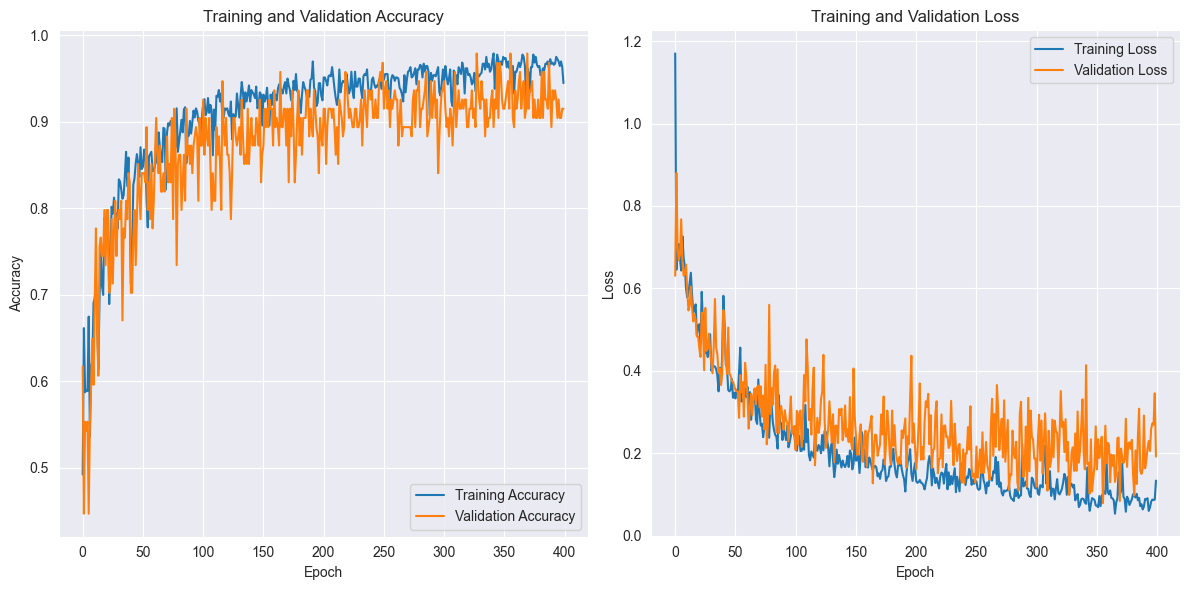

In [48]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 [==============================] - 2s 268ms/step


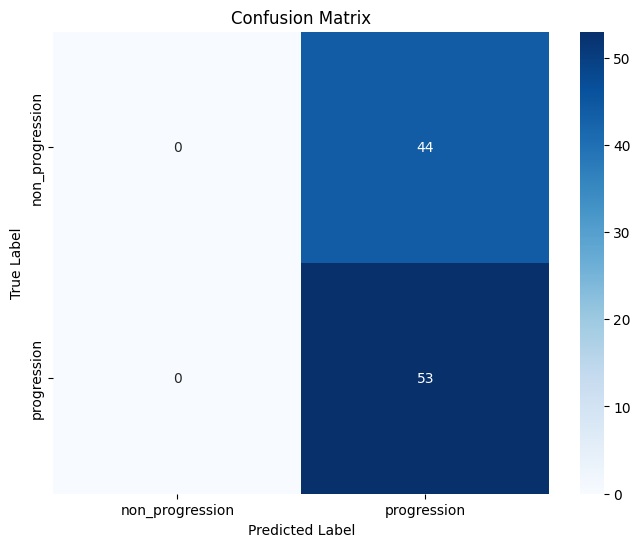

Classification Report:
                  precision    recall  f1-score   support

non_progression       0.00      0.00      0.00        44
    progression       0.55      1.00      0.71        53

       accuracy                           0.55        97
      macro avg       0.27      0.50      0.35        97
   weighted avg       0.30      0.55      0.39        97



C:\Users\Sid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels for the test dataset
true_labels = test_ds.classes

# Generate predictions using the trained model
predictions = model.predict(test_ds)

# Convert predictions to class labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['non_progression', 'progression'], yticklabels=['non_progression', 'progression'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display the classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['non_progression', 'progression'])
print("Classification Report:\n", class_report)


In [109]:
model.save('progression_detection.h5')

C:\Users\Sid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

# Function to predict the category of a retinal fundus image
def predict_image_classification(image_path, model):
    # Load the image file, targeting a size matching the model's expected input
    img = load_img(image_path, target_size=(img_height, img_width))

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Expand dimensions to match the model's expected input format
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Preprocess the image for the InceptionV3 model
    img_preprocessed = preprocess_input(img_array_expanded)

    # Predict the class of the image
    prediction = model.predict(img_preprocessed)

    # Convert the prediction to a readable class
    predicted_class = np.argmax(prediction, axis=1)

    # Map the predicted class index to its corresponding label
    if predicted_class[0] == 0:
        print("The image is classified as: non_progression")
    else:
        print("The image is classified as: progression")

# Example usage
image_path = 'test.jpg'  # Replace this with the path to your retinal fundus image
predict_image_classification(image_path, model)

1/1 [==============================] - 0s 32ms/step
The image is classified as: progression
